# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Voronoi's reduction, in dimension 4 and 5


This notebook presents some tensor decomposition techniques that are at the foundation of our anisotropic PDE discretizations on cartesian grids. The general objective is to express a given symmetric positive definite (SPD) matrix $D$ under the form
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T,
$$
where $\lambda_i \geq 0$ is a non-negative weight, and $e_i \in Z^d$ is an integral offset.
This decomposition is a starting point for the design of various numerical schemes, for both first order and second order, linear and non-linear PDEs, which will be discussed in the subsequent notebooks.

The techniques used for constructing the above decomposition are non-trivial, related to classical yet subtle tools of discrete geometry. In this notebook, we however insist more on their properties 

This notebook is devoted to the decomposition of SPD tensors of size $d \times d$, where the dimension $d\in \{4,5\}$. A simpler set of techniques applies in dimension $d \in \{2,3\}$, see the notebook [I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/TensorSelling.ipynb)

**Acknowledgement.** 

The experiments presented in this notebook are part of ongoing research, with PhD student Guillaume Bonnet, in co-direction with [Frederic Bonnans](http://www.cmap.polytechnique.fr/~bonnans/).


**References.**

The tensor decomposition presented in this notebook is a central ingredient of the following paper:

Mirebeau, J.-M. (2017, April 12). Riemannian fast-marching on cartesian grids using Voronoi's first reduction of quadratic forms. HAL (Preprint).

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Computing the decomposition of a tensor](#1.-Computing-the-decomposition-of-a-tensor)
    * [1.1 Case of a  $4 \times 4$ tensor](#1.1-Case-of-a--$4-\times-4$-tensor)
    * [1.2 Case of a $5\times 5$ tensor](#1.2-Case-of-a-$5\times-5$-tensor)
    * [1.3 A field of tensors](#1.3-A-field-of-tensors)
  * [2. Under the hood: Voronoi's first reduction of tensors.](#2.-Under-the-hood:-Voronoi's-first-reduction-of-tensors.)
    * [2.1 Comparing the objective function](#2.1-Comparing-the-objective-function)
    * [2.2 Non-uniqueness of the maximizer](#2.2-Non-uniqueness-of-the-maximizer)
  * [3. Properties of Voronoi's reduction](#3.-Properties-of-Voronoi's-reduction)
    * [3.1 Smallness of the offsets](#3.1-Smallness-of-the-offsets)
    * [3.2 Stability](#3.2-Stability)
    * [3.3 Spanning, of the lattice $Z^d$ by the tensor decomposition offsets.](#3.3-Spanning,-of-the-lattice-$Z^d$-by-the-tensor-decomposition-offsets.)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('TensorVoronoi','Algo')

In [2]:
from agd import LinearParallel as lp
from agd.Selling import GatherByOffset
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorVoronoi'

The routines for tensor decomposition are for efficiency purposes provided in a small c++ library, named FileVDQ where VDQ stands for "Voronoi Decomposition of Quadratic forms". This is in contrast with the two and three dimensional cases, where the decomposition algorithm is coded in Python (the c++ library can also be used in smaller dimensions). A function named `VoronoiDecomposition` provides the interface.

In [3]:
from agd.Eikonal import VoronoiDecomposition

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 0.1 Optional configuration

Uncomment the following line to use the GPU implementation of Voronoi's decomposition.

In [5]:
#VoronoiDecomposition.default_mode = 'gpu_transfer'

## 1. Computing the decomposition of a tensor

We illustrate our tensor decomposition method on random positive definite matrices, of the form 
$$
    D = A^T A,
$$
where $A$ is a square matrix with random coefficients w.r.t. the Gaussian normal law.

In [6]:
def MakeRandomTensor(dim,shape = tuple()):
    A = np.random.standard_normal( (dim,dim) + shape )
    return lp.dot_AA(lp.transpose(A),A)

In [7]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

The inserse operation to tensor decomposition is, of course, reconstruction, defined by 
$$
    (\lambda_i, e_i)_{i=1}^I \mapsto D = \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T
$$

In [8]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [9]:
def LInfNorm(a):
    return np.max(np.abs(a))

### 1.1 Case of a  $4 \times 4$ tensor

In [10]:
D4 = MakeRandomTensor(4)

In [11]:
print(D4)

[[ 0.58050469 -0.73151355 -0.24786425  0.65940888]
 [-0.73151355  4.02894983  2.589515    0.43286178]
 [-0.24786425  2.589515    6.10351105  3.38411893]
 [ 0.65940888  0.43286178  3.38411893  3.44164748]]


In [12]:
coefs,offsets = VoronoiDecomposition(D4)

Our decomposition, of a $4 \times 4$ SPD tensor, involves either $10$ or $12$ coefficients and offsets. 
If the tensor is randomly generated, then each possibility arises with positive probability, in approximately half the cases.

For uniformity of the data structures, we always return $12$ coefficients and offsets, but the last two are often zero.

In [13]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [1.73966329 0.06642844 0.15724673 0.18106995 0.16328382 0.00623787
 1.38738859 0.93488664 0.00623787 0.27498616 0.302155   0.00623787]
Offsets : 
 [[ 0  1  1  1  1  1  0  0  0  0  0  1]
 [ 1 -1 -2 -1 -1  0  0  1  1  0  1 -1]
 [ 0  1 -1  0 -1  1  1  2  1  1  1  0]
 [ 0  2  1  1  1  2  1  1  0  0  1  2]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [14]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D4-Reconstruct(coefs,offsets)))
assert np.allclose(D4,Reconstruct(coefs,offsets))

Minimal coefficient :  0.006237872725368021
Reconstruction error :  4.440892098500626e-16


Drawing another tensor at random, we observe only $10$ non-zero coefficients and offsets.

In [15]:
MakeRandomTensor(4), MakeRandomTensor(4); # Please do not comment

In [16]:
D4b= MakeRandomTensor(4)
coefs,offsets = VoronoiDecomposition(D4b)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.07072164 0.67380855 0.17172141 0.01978496 0.18202013 2.27992042
 0.00239801 0.33441994 0.49956443 1.96547794 0.         0.        ]
Offsets : 
 [[ 0  1  0  0  0  0  1  1  1  0  0  0]
 [ 2 -1  1  1  1  1  1  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0 -1  0  1  0  0]
 [ 1 -1  1  0  1  0  0 -1  0  1  0  0]]


In [17]:
assert np.allclose(D4b,Reconstruct(coefs,offsets))

### 1.2 Case of a $5\times 5$ tensor

In [18]:
D5 = MakeRandomTensor(5)

In [19]:
print(D5)

[[ 1.25435342e+01 -4.42058086e-01 -2.72865159e+00 -1.58137791e+00
   5.02471743e-01]
 [-4.42058086e-01  2.94553339e+00 -8.03620276e-03  6.12724263e-01
   1.51099932e+00]
 [-2.72865159e+00 -8.03620276e-03  3.34380956e+00  6.75320007e-01
   1.71840079e+00]
 [-1.58137791e+00  6.12724263e-01  6.75320007e-01  3.39001528e+00
  -6.60686207e-01]
 [ 5.02471743e-01  1.51099932e+00  1.71840079e+00 -6.60686207e-01
   3.13656032e+00]]


In [20]:
coefs,offsets = VoronoiDecomposition(D5)

Our decomposition of $5 \times 5$ SPD tensors always involves $15$ coefficients and offsets. (Some coefficients may vanish but, contrary to the four dimensional case, this occurs with probability zero.)

In [21]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.9851582  5.91306866 0.16216179 0.16119026 0.54030804 1.33730873
 0.8835638  0.80238202 0.24029056 0.09283979 0.10087599 0.28825227
 0.34849989 0.5609605  0.37243394]
Offsets : 
 [[ 1  1  0  2  0  0  1  1  1  1  1  1  1  2  0]
 [-1  0  1  0  0  0  1  0  0 -1  1  0 -1  0  1]
 [ 0  0  0 -1  0  1  0 -1  0 -1 -1 -1  0 -1  0]
 [-1  0  0 -1  1  0  0 -1  1  0  0  1  0  0 -1]
 [ 0  0  1  0  0  1  1  0  0 -1  0 -1  0  0  1]]


In [22]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D5-Reconstruct(coefs,offsets)))

Minimal coefficient :  0.09283978602904651
Reconstruction error :  1.7763568394002505e-15


In [23]:
assert np.allclose(D5,Reconstruct(coefs,offsets),atol=1e-5) # atol is for float32

### 1.3 A field of tensors

When provided with a numerical array shaped as $(d,d,n)$, or $(d,d,n_1,\cdots,n_d)$, our tensor decomposition routine automatically threads over the inner dimensions $n$ or $n_1,\cdots, n_d$.

<!---
**TODO** Perform a reshape in VDEUtils python library, avoiding such restrictions, and simplifying the c++ code ?
In fact the present code makes sense, in case one wants to implement anisotropic diffusion directly in c++.

This facility is intended for use in adaptive finite difference PDE schemes.
Note, however, that the field of $d \times d$ tensors, may only have depth $1$ or $d$.
-->

In [24]:
D4_field = MakeRandomTensor(4,(10,))
# Alternatively
#D4_field = MakeRandomTensor(4,(2,2,2,2))
#D5_field = MakeRandomTensor(4,(2,2,2,2,2))

In [25]:
coefs,offsets = VoronoiDecomposition(D4_field)

In [26]:
assert np.allclose(D4_field,Reconstruct(coefs,offsets))

## 2. Under the hood: Voronoi's first reduction of tensors.

The tensor decompositions computed in this notebook are the result of a linear program, which is well known in the field of lattice geometry (a subfield of discrete computational geometry).
The dual to this linear program is often referred to as Voronoi's first reduction. 

In detail, the decomposition of a tensor $D$ proceeeds by maximizing the sum of the weights
$$
    \text{maximize} \quad 
    \sum_{1 \leq i \leq I} \lambda_i,
$$
while the constraints enforce that the decomposition is valid
$$
    \text{subject to} \quad 
    \lambda_i \geq 0, \quad 
    e_i \in Z^d, \quad
    \text{and}  \quad
    \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T = D.
$$
Note that the vectors $e_i \in Z^d$ are not fixed a-priori, and that $I$ is not bounded a-priori, hence that optimization problem is strictly speaking infinite dimensional.

Two motivations can be invoqued to justify the choice of objective function, which is the sum of the decomposition coefficients. Indeed, this approach:
* Promotes small offsets. This is clear in view of the trace identity
$$
    \mathrm{Tr}(D) = \sum_{1 \leq i \leq I} \lambda_i \|e_i\|^2,
$$
which relate the coefficients magnitudes with the offsets norms.
* Is highly symmetrical, allowing for efficient implementations. The numerical cost of our optimized implementation is expected to be low enough to compute one such decomposition for each point of the discretization grid of a PDE.

It can be shown that Voronoi's first reduction, the above linear program, has at least one solution for each positive definite symmetric matrix $D$. 
Interestingly however, the solution may not be unique, so that a selection principle becomes necessary. More precisely:
* In dimension $2$ and $3$, the linear program actually always has a unique solution, which can also be computed using Selling's algorithm, see the relevant notebook [I Tensor decomposition, dimensions 2 and 3](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/TensorSelling.ipynb).
* In dimension $4$, the linear program either has a unique solution, or a set of solutions that forms a triangle (equilateral) in the coefficients space. In the latter case, the triangle barycenter is returned.
* In dimension $5$, the linear program often has a $5$ dimensional set of solutions, forming a convex polyhedron. A vertex of this polyhedron is selected, in a consistent manner so as to ensure the continuity of the coefficients. 

### 2.1 Comparing the objective function

We empirically check, on a random example, that our tensor decomposition yields a large sum of coefficients.

For that purpose, we generate a matrix $D = \sum_{i=1}^I \lambda_i e_i e_i^T$ by drawing randomly the weights 
$(\lambda_i)$ and offsets $e_i$.

In [27]:
coefs = np.random.standard_normal(15)**2
offsets = np.random.uniform(-5,5,(5,15)).astype(int)

In [28]:
D5b = Reconstruct(coefs,offsets)

In [29]:
print("Sum of coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets ; \n", offsets)

Sum of coefficients :  26.029629166601506
Coefficients :  [1.64010186e-01 1.58982835e+00 8.42470554e-01 4.50354692e+00
 1.06598451e+00 2.30848509e+00 2.34482637e-01 1.60506386e+00
 5.00796073e-01 1.96975685e-01 6.00057917e-01 8.59200099e-01
 3.54326801e-03 1.05058140e+01 1.04937004e+00]
Offsets ; 
 [[-3  0 -1  1  1 -4 -1  1  0  3  1 -3 -4  1 -4]
 [ 0  4  0 -1  1  0  0  4 -1  4  4 -3 -4 -3 -4]
 [-4  1 -4 -1  3 -4  3 -2 -3  1  1  3  2  3 -2]
 [-3  2  3  4  0 -1  2 -1  4  3  0  2  2 -3  4]
 [ 0  3 -1  3 -1 -4  4 -4 -1  4  4  0  1  0 -2]]


Our tensor decomposition yields, as expected, a larger sum of coefficients.

In [30]:
coefs,offsets = VoronoiDecomposition(D5b)

In [31]:
print("Sum of new coefficients", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets ; \n", offsets.astype(int))

Sum of new coefficients 411.51346376975914
Coefficients :  [  0.45441405  42.80148792   3.89099871  80.67126692  10.11443835
   2.63908912   0.35419077  26.78412094  23.91171188  17.48091081
   7.15102796  10.27693749  61.22356591 100.25658831  23.50271461]
Offsets ; 
 [[ 1  1  0  0  1  1  1  0  0  1  0  1  0  0  0]
 [ 1  0  0  0  0  0  1  1  0  0  0  0  1  1  0]
 [ 0  1  0  0  1  0  0 -1  0  1  1  0 -1  0  1]
 [ 0  0  0  1 -1  0  0  0  1 -1  0  0  1  0 -1]
 [ 1  1  1  1  1  1  0  0  0  0  0  0  0  0  0]]


In this second example, we expose the non-linearity of our tensor decomposition by comparing:
* The average of the decompositions of two tensors.
* The decomposition of the average tensor.

In [32]:
coefs0,_  = VoronoiDecomposition(D4)
coefs1,_  = VoronoiDecomposition(D4b)
coefs01,_ = VoronoiDecomposition(D4+D4b)
print("Sum of coefficients, average decomposition : ", 0.5*(np.sum(coefs0)+np.sum(coefs1)))
print("Sum of coefficients, decomposition of the average : ", 0.5*np.sum(coefs01))

Sum of coefficients, average decomposition :  5.712829835862354
Sum of coefficients, decomposition of the average :  7.5782526717648695


### 2.2 Non-uniqueness of the maximizer

We illustrate a case where a tensor $D$ admits several optimal decompositions, all maximizing the coefficients sum.
The specific example chosen is also interesting from the point of view of the spanning property, discussed in the next section.

Note that the choice of theses offsets is very specific, coming from a fine theoretical description of Voronoi's first reduction, the associated *perfect forms*, and their minimal vectors.

In [33]:
coefs_NonUnique = np.array([1,1,1,1])
offsets_NonUnique = np.transpose(np.array([[0,0,1,0],[0,1,0,-1],[1,-1,0,0],[1,0,-1,1]]))

In [34]:
print("Sum of coefficients : ", np.sum(coefs_NonUnique))

Sum of coefficients :  4


In [35]:
D4_NonUnique = Reconstruct(coefs_NonUnique,offsets_NonUnique)

In [36]:
coefs,offsets = VoronoiDecomposition(D4_NonUnique)

The tensor decomposition returned by our software is different, but the coefficients sum is no smaller.

In [37]:
print("Sum of new coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Sum of new coefficients :  4.000000000000001
Coefficients :  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Offsets : 
 [[ 0  0  0  1  0  0  1  0  1  1  1  1]
 [ 0  0  1  0  1  0  0  1 -1 -1  0 -1]
 [ 0  1  0  0  0  1 -1 -1  0  0 -1 -1]
 [ 1  0  0  0 -1 -1  0  0  0  1  1  1]]


In [38]:
assert np.allclose(D4_NonUnique, Reconstruct(coefs,offsets) )

## 3. Properties of Voronoi's reduction

We discuss three properties of the implemented tensor decomposition
$$
    D \mapsto (\lambda_i, e_i)_{i=1}^I,
$$
which seems to be desirable from the implementation point of view. There properties are
* **Smallness** of the offsets $e_i \in Z^d$.
* **Stability** of the coefficients $\lambda_i \in R$
* **Spanning** of the full lattice $Z^d$, by the offsets $(e_i)_{i=1}^I$. (Not always satisfied if $d=5$.)

### 3.1 Smallness of the offsets

By design, by the choice of the objective function in the underlying linear program, Voronoi's first reduction promotes small offsets in the tensor decompositions produced.
It is also possible to bound the offsets norm in terms of the tensor condition number
$$
    \|e_i\| \leq C \mu(D)^{d-1}
$$
where $\mu(D) := \sqrt{\|D\| \|D^{-1}\|}$ and $C$ is an absolute constant. 


Note that this theoretical bound is not sharp in dimension $d=3$, in that case one can prove that $\|e_i\| \leq C \mu(D)$, and may not be sharp either in higher dimension.

In [39]:
mu=10

We generate a SPD tensor with condition number $\mu$, and compare $\max_{1 \leq i \leq d} \|e_i\|$ with $\mu$. Successively $d=4$ and then $d=5$.

In [40]:
v = np.random.standard_normal(4)
v=v/np.linalg.norm(v)
D4_cigar = (mu**2-1)*lp.outer_self(v) + np.eye(4)

In [41]:
coefs,offsets = VoronoiDecomposition(D4_cigar)

In [42]:
print("mu : ",mu)
print("max offset norm : ",np.max(np.linalg.norm(offsets,axis=0)))
print("Offsets : \n", offsets.astype(int))

mu : 

 10
max offset norm :  6.708203932499369
Offsets : 
 [[ 3  1  2  1  2  1  4  2  3  1  0  0]
 [-2 -2 -1  0 -2 -1 -4 -2 -3 -1  0  0]
 [ 2  1  1  0  2  1  3  1  2  1  0  0]
 [ 1  1  1  0  1  0  2  1  2  1  0  0]]


In [43]:
v = np.random.standard_normal(5)
v=v/np.linalg.norm(v)
D5_cigar = (mu**2-1)*lp.outer_self(v) + np.eye(5)

In [44]:
coefs,offsets = VoronoiDecomposition(D5_cigar)

In [45]:
print("mu : ",mu)
print("max offset norm : ",np.max(np.linalg.norm(offsets,axis=0)))
print("Offsets : \n", offsets.astype(int))

mu :  10
max offset norm :  6.855654600401044
Offsets : 
 [[ 1  2  0  2  0  1  1  1  1  0  1  1  1  0  1]
 [ 0  0  0  1  1  0  0  0  0  1  0  0  1  0  1]
 [ 3  5  1  5  1  2  2  4  2  0  3  3  2  1  3]
 [-2 -4 -1 -4 -1 -2 -1 -3 -2  0 -3 -2 -2  0 -2]
 [ 1  1  0  1  0  1  0  1  0  0  1  0  0  0  0]]


### 3.2 Stability

The implemented tensor decompositions are stable, in the sense that the weight associated with and offset depends continuously on the tensor decomposed.
Mathematically, for any $e \in Z^d / \{\pm 1\}$, the following mapping is locally Lipschitz 
$$
    D \mapsto \lambda^e(D),
$$
where $\lambda^e(D)$ is the coefficient of $e e^T$ in the decomposition of $D$.

This continuity is achieved thanks to an appropriate selection principle, in the cases where the linear program defining Voronoi's first reduction does not have unique maximizer. Note that the coefficient of an offset $e_i$ and of its opposite $-e_i$ are regarded as identical.

We check the coefficients continuity by interpolating between two randomly drawn tensors.

In [46]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(np.array([(1-t)*a + t*b for t in T]),0,-1)

In [47]:
T_interp, D4_interp = Interpolate(MakeRandomTensor(4),MakeRandomTensor(4))

In [48]:
coefs,offsets = VoronoiDecomposition(D4_interp)

In [49]:
print("Reconstruction error : ", LInfNorm(D4_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D4_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  3.2751579226442118e-15


In [50]:
decomp = GatherByOffset(T_interp,coefs,offsets)

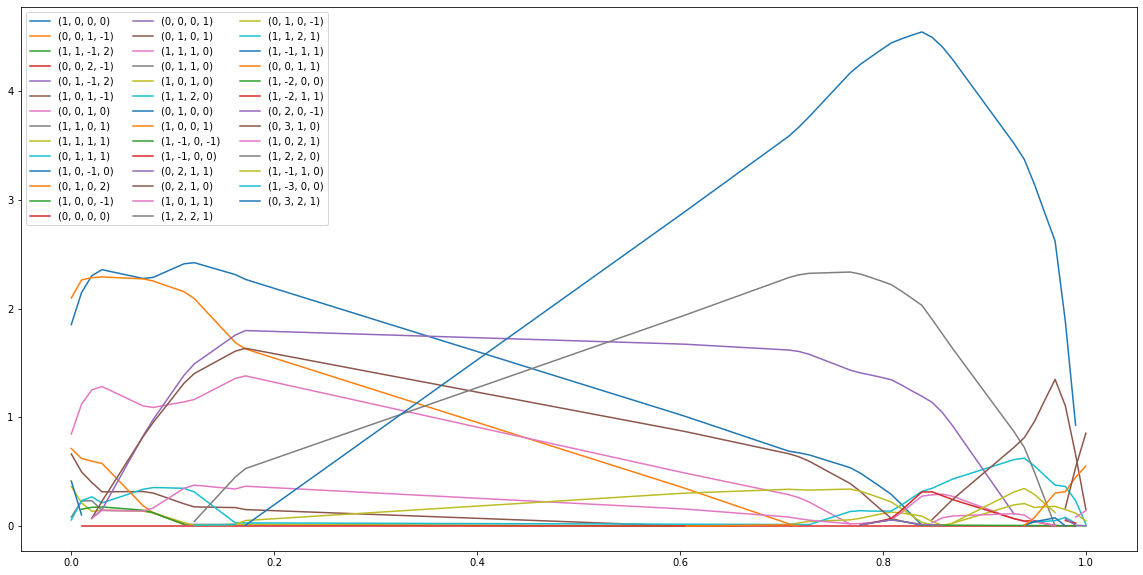

In [51]:
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")

In [52]:
T_interp, D5_interp = Interpolate(MakeRandomTensor(5),MakeRandomTensor(5))
coefs,offsets = VoronoiDecomposition(D5_interp)
print("Reconstruction error : ", LInfNorm(D5_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D5_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  1.0658141036401503e-14


**CPU vs GPU implementation.** The CPU decomposition is stable w.r.t the inputs, locally Lipschitz more precisely. In contrast, the GPU implementation is discontinuous. Indeed, the code devoted to the selection of the decomposition in cases of non-uniqueness requires double precision floating point arithmetic, and for this reason it was not ported to the GPU.

<!---This is due to a bit of code (selection of the decomposition in cases of non-uniqueness) which was not ported to the GPU, and could easily be fixed in the future.--->

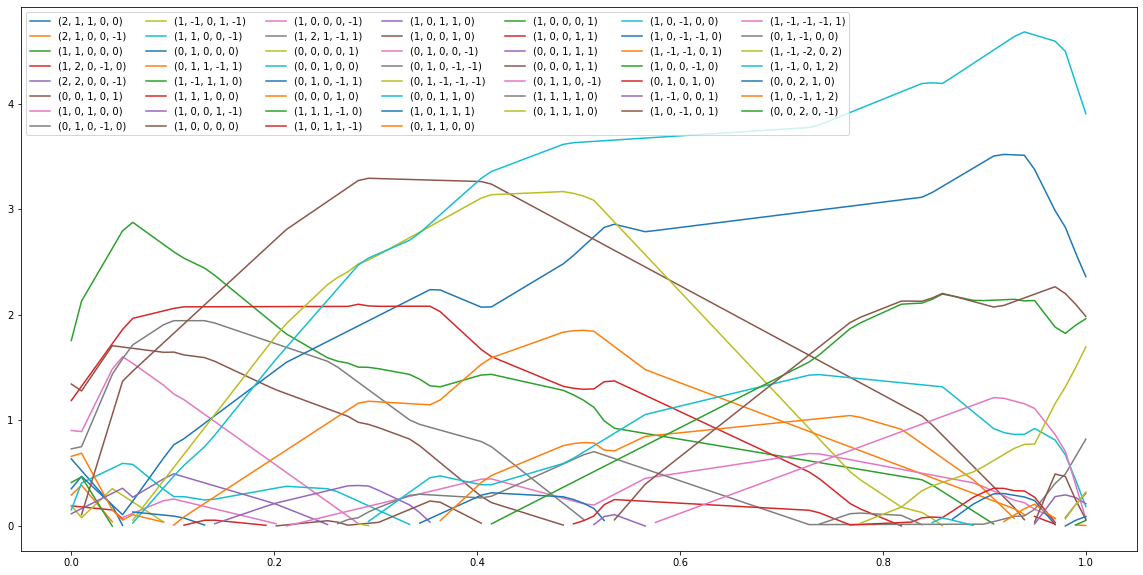

In [53]:
decomp = GatherByOffset(T_interp,coefs,offsets)
fig = plt.figure(figsize=(20,10))
for offset,(time,coef) in decomp.items():
    plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=7);
savefig(fig,"Coefs_Vor5.pdf")

In [54]:
print("Matrix eigenvalues : ",np.linalg.eigvals(D5_interp[...,0]))
print("Coefficients : ", coefs[...,0])
print("Offsets : \n", offsets[...,0].astype(int))

Matrix eigenvalues :  [16.09060444  5.79356695  5.18317148  0.28922182  0.53419682]
Coefficients :  [0.63645127 0.29439048 1.75636743 0.19158944 0.20794792 1.34492959
 0.90525318 0.7313639  0.19515092 0.15422503 0.35351432 0.66033955
 0.41295122 1.18902423 0.11726199]
Offsets : 
 [[ 2  2  1  1  2  0  1  0  1  1  0  0  1  1  1]
 [ 1  1  1  2  2  0  0  1 -1  1  1  1 -1  1  0]
 [ 1  0  0  0  0  1  1  0  0  0  0  1  1  1  0]
 [ 0  0  0 -1  0  0  0 -1  1  0  0 -1  1  0  1]
 [ 0 -1  0  0 -1  1  0  0 -1 -1  0  1  0  0 -1]]


In [55]:
print("Decomposed matrix : \n",D5_interp[...,0])

Decomposed matrix : 
 [[ 9.47698215e+00  5.56816864e+00  3.78013118e+00  5.33774689e-01
  -1.47131475e+00]
 [ 5.56816864e+00  7.98192782e+00  2.07286383e+00 -2.38298448e+00
  -9.02088673e-03]
 [ 3.78013118e+00  2.07286383e+00  5.14894904e+00 -2.47388327e-01
   2.00526914e+00]
 [ 5.33774689e-01 -2.38298448e+00 -2.47388327e-01  2.30865702e+00
  -9.72752458e-01]
 [-1.47131475e+00 -9.02088673e-03  2.00526914e+00 -9.72752458e-01
   2.97424548e+00]]


### 3.3 Spanning, of the lattice $Z^d$ by the tensor decomposition offsets. 

The tensor decompositions presented in this notebook are intended as the foundation to finite difference schemes. 
The offsets $(e_i)_{i=1}^I$ involved in the decomposition of a tensor $D = D(x)$ appearing in the discretized PDE, thus determine the local connectivity of the discretization grid around $x$.

In order to avoid chessboard artifacts, it is desirable that the offsets span the lattice $Z^d$ (using integer coefficients), which is referred to as the *spanning property*. Let us recall that a set of $d$ vectors $e_1,\cdots,e_d \in Z^d$ span the lattice $Z^d$ with integer coefficients iff
$$
    \det(e_1,\cdots,e_d)=1.
$$

*General findings* In dimension $d\leq 4$, the spanning property is guaranteed for the implemented tensor decomposition. In dimension $d=5$, it is not, but we provide a fix for it. However, it is not clear that this fix is desirable in practical implementations.

**Four dimensional decompositions span**

We can guarantee, by theoretical arguments, that our decompositions of $4\times 4$ SPD tensors obey the spanning property.

In [56]:
coefs,offsets = VoronoiDecomposition(D4)

In [57]:
np.linalg.det(offsets[:,0:4])

-1.0

**An intruiguing special case**

Interestingly, there are exists tensors $D\in S_4^{++}$ admitting an optimal decomposition, in the sense of Voronoi's first reduction see above, which is not spanning.

In [58]:
print("A tensors admitting a non-unique optimal decomposition : ", D4_NonUnique)
print("Coefficients of an optimal decomposition : ", coefs_NonUnique)
print("Offsets of an optimal decomposition : ", offsets_NonUnique)

A tensors admitting a non-unique optimal decomposition :  [[ 2 -1 -1  1]
 [-1  2  0 -1]
 [-1  0  2 -1]
 [ 1 -1 -1  2]]
Coefficients of an optimal decomposition :  [1 1 1 1]
Offsets of an optimal decomposition :  [[ 0  0  1  1]
 [ 0  1 -1  0]
 [ 1  0  0 -1]
 [ 0 -1  0  1]]


In [59]:
np.linalg.det(offsets_NonUnique)

-2.0

However, our tensor decomposition method selects a different decomposition, which is spanning.

In [60]:
coefs,offsets = VoronoiDecomposition(D4_NonUnique)

In [61]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Offsets : 
 [[ 0  0  0  1  0  0  1  0  1  1  1  1]
 [ 0  0  1  0  1  0  0  1 -1 -1  0 -1]
 [ 0  1  0  0  0  1 -1 -1  0  0 -1 -1]
 [ 1  0  0  0 -1 -1  0  0  0  1  1  1]]


In [62]:
np.linalg.det(offsets[:,0:4])

1.0

**Five dimensional decompositions may not span**

We present below a tensor $D\in S_5^{++}$ whose Voronoi's decomposition is unique and non-spanning. Note that the choice of these offsets is very specific, coming from a fine theoretical description of Voronoi's first reduction, the associated *perfect forms*, and their minimal vectors.

In [63]:
coefs_NonSpanning = np.array([1,1,1,1,1])
offsets_NonSpanning = np.transpose(np.array(
    [[0,0,1,0,1],[0,0,1,1,0],[0,1,0,0,0],[1,0,0,0,0],[1,1,0,1,1]]))

In [64]:
D5_NonSpanning = Reconstruct(coefs_NonSpanning,offsets_NonSpanning)

In [65]:
print(np.linalg.det(offsets_NonSpanning))

-2.0


As can illustrated below, the explicit decomposition in terms of coefficients and offsets maximizes the sum of the weights (a property which defines Voronoi's reduction). In addition, and contrary to the previous four dimensional example, this maximizer is non-degenerate and attained for a unique decomposition - the one represented above which is reproduced by our decomposition algorithm.

In [66]:
coefs,offsets = VoronoiDecomposition(D5_NonSpanning)

In [67]:
print("Sum of coefficients : ", np.sum(coefs))
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Sum of coefficients :  5.0
Coefficients :  [0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
Offsets : 
 [[ 1  1  0  1  1  0  1  0  1  1  0  1  0  1  0]
 [ 0  0  0  1  0  0  0  1  1  0  0  1  1  1  1]
 [ 0  0  1  0  0  1  1  0  0  1  1  0  0  1 -1]
 [ 0  0  1  0  1  0  1  0  1  1  0  1  0  1  0]
 [ 1  0  0  1  0  1  0  1  0  1  0  1  0  1  0]]


In [68]:
print(offsets[:,coefs>0].astype(int)) # Same as offsets_NonUnique

[[1 0 0 1 0]
 [0 0 0 1 1]
 [0 1 1 0 0]
 [0 1 0 1 0]
 [0 0 1 1 0]]


**A fix for the spanning property**

Let $D$ be a PSD tensor. Then it is always possible to construct a decomposition of $D$ with the spanning property by adding the decompositions of 
$$
    D = \lambda I + (D-\lambda I),
$$
where $\lambda>0$ is sufficiently small, so that $D-\lambda I$ is positive definite. A natural choice is to set $\lambda := \frac 1 2 \lambda_{\min}(D)$, half the smallest eigenvalue of $D$.

Recalling that the decomposition of the identity matrix is
$$
    I = \sum_{1 \leq i \leq d} e_i e_i^T,
$$
we obtain a tensor decomposition which is spanning. 

In [69]:
alpha = np.min(np.linalg.eigvals(D5_NonSpanning))/2

In [70]:
coefs,offsets = VoronoiDecomposition(D5_NonSpanning - alpha*np.eye(5))
coefs = np.concatenate([alpha*np.ones(5),coefs],axis=0)
offsets = np.concatenate([np.eye(5),offsets],axis=1)

The new decomposition reproduces the norm, and is spanning, as checked below.

In [71]:
print(LInfNorm(D5_NonSpanning - Reconstruct(coefs,offsets)))

0.0


In [72]:
print("Coefs : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefs :  [0.15933468 0.15933468 0.15933468 0.15933468 0.15933468 0.36266129
 0.15933468 0.15933468 0.15933468 0.52199597 0.15933468 0.31866936
 0.52199597 0.52199597 0.15933468 0.         0.         0.36266129
 0.15933468 0.15933468]
Offsets : 
 [[ 1  0  0  0  0  0  1  1  1  1  1  1  0  0  0  1  1  1  0  0]
 [ 0  1  0  0  0  1  0  0  0  1  1  1  0  0  1  1  2  0  1  1]
 [ 0  0  1  0  0  0  1  0  0  0  1 -1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  1  0  1  1  0  1  0  1  0  1  0  0  1]
 [ 0  0  0  0  1  0  1  0  1  1  1  0  0  1  1  1  1  0  1  0]]


However, this decomposition is not optimal from the point of view of the sum of weights, and of the offsets norms.

In [73]:
print("Sum of coefficients : ", np.sum(coefs))
print("Max offset norm : ", np.max(np.linalg.norm(offsets,axis=0)))

Sum of coefficients :  4.521995965407467
Max offset norm :  2.6457513110645907


In [74]:
print("Optimal sum of coefficients : ", np.sum(coefs_NonSpanning))
print("Canonical offset norm : ", np.max(np.linalg.norm(offsets_NonSpanning,axis=0)))

Optimal sum of coefficients :  5
Canonical offset norm :  2.0
